In [2]:
import numba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp
from numba import jit

In [7]:
y

array([0.8849385 , 0.27994735, 1.11044606, 0.63471515])

In [9]:
y

array([1.57751094, 0.52726654, 0.79548049, 1.34570587])

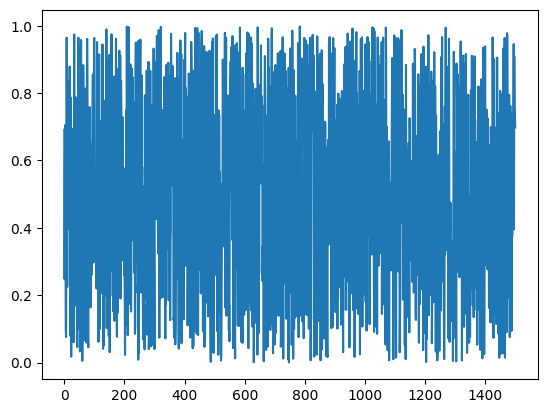

In [10]:
n = 30
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
#  we let r=25
r= 15
y = np.zeros(n) #initialising y array
sigmay = 0.001
for i in range(n):
    yTemp = X[i][0:r].sum() + np.random.normal(0, sigmay) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [ ]:
def splitGibbs(sigma1, sigma2, sigmay, X, y, niter=1000):
    gamma = 0.1
    rho = 1
    p = len(X[1])
    n = len(X)
    b = p + n
    theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    # for i in range(r): theta[i] = 1                                
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
    samples = []
    for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            if i == 0:
                Alist = A
                AtA = np.array([np.matmul(A.T, A)])
            else:
                Alist = np.vstack((Alist, A))
                AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

    for t in range(niter):                                              #Beginning of Split Gibbs Sampling
        for i in range(b):
            if i <= p-1:
                sigsig = sigma2 / sigma1
                Aitheta = np.matmul(Alist[i], theta)
                sigmaz = 1 - sigsig**2
                w2 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(sigmaz) * (np.linalg.norm(Aitheta))**2/2)))
                w1 = 1 - w2
                U = np.random.uniform(0,1)
                if U > w2:
                    mu = (sigmaz) * Aitheta
                    z = np.append(z, np.random.normal(mu, sigmaz))
                else:
                    z = np.append(z, 0)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
            else:
                z = np.append(z, y[i-p] / sigmay)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))

        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
        samples.append(theta.T[0])

        print("Number of samples is" % (str(len(samples))))
    return samples


# trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 100000)

In [ ]:
def metroHastings(sigma1, sigma2, sigmay, sigma_theta, X, y, niter = 1000):
    p = len(X[1])
    n = len(X)
    b = p + n
    t = 1
    gamma = 0.1
    no_accept = 0
    theta_0 = np.array([np.zeros(p)]).T                                     #--- initialising theta as zero vectors
    # theta_0 = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1))
    # for i in range(r): theta_0[i] = 1
    thetas = theta_0.T[0]

    while t < niter:
        t += 1
        #symmetric random walk
        theta_c = np.reshape(np.random.multivariate_normal(theta_0.T[0], np.identity(p)*sigma_theta), (-1, 1))
        log_joint_candidate = ssp(theta_c, gamma, X, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
        log_joint_old = ssp(theta_0, gamma, X, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
        mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR
        # print(mhr)
        U = np.random.uniform(0,1)
        if U <= np.minimum(mhr, 1):
            theta_0 = theta_c
            thetas = np.vstack((thetas, theta_c.T[0]))
            no_accept += 1
        else:
            thetas = np.vstack((thetas, theta_0.T[0]))
            # print(thetas)
    
    print("Acceptance Rate is %s, with total number of acceptance of %s" % (str(no_accept/niter), str(no_accept)))
    return np.asarray(thetas)


# samples = metroHastings(sigma1 = 1, sigma2 = 0.01, sigmay = 0.01, sigma_theta = 1, X = X, y = y, niter = 50000)
# samples = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, sigma_theta = 1, X = X, y = y, niter = 100000)

In [ ]:
trace-sgs = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, X = X, y = y, niter = 100000)

sample-sgs = tf.convert_to_tensor(trace-sgs, dtype=tf.float32)
plt.plot(sample-sgs)
mean-sgs, variance-sgs = tf.nn.moments(sample-sgs, axes=0)
print(mean)

trace-mh = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, sigma_theta = 0.001, X = X, y = y, niter = 100000)
sample-mh = tf.convert_to_tensor(trace-mh, dtype = tf.float32)
plt.plot(sample-mh)
# mean-mh, variance = tf.nn.moments(trace, axes=0)
mean-mh = tf.math.reduce_mean(sample-mh, axis=0)
print(mean-mh)